## Twitter Project to Find Fake Followers

Run the code lines below after reading the readme.md for this project

In [6]:
from __future__ import print_function
import os
import time
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
from twitter import Twitter, OAuth

In [7]:
USER_TO_ANALYZE = 'oyetola__'
OAUTH_TOKEN = ''
OAUTH_SECRET = ''
CONSUMER_KEY = ''
CONSUMER_SECRET = ''

In [8]:
twitter_connection = Twitter(auth=OAuth(OAUTH_TOKEN, OAUTH_SECRET, CONSUMER_KEY, CONSUMER_SECRET))

In [9]:
pbar = tqdm()
pbar.write('Collecting list of Twitter followers for @{}'.format(USER_TO_ANALYZE))

In [10]:
rl_status = twitter_connection.application.rate_limit_status()
if rl_status['resources']['followers']['/followers/ids']['remaining'] <= 0:
    sleep_until = rl_status['resources']['followers']['/followers/ids']['reset']
    sleep_for = int(sleep_until - time.time()) + 10 # wait a little extra time just in case
    if sleep_for > 0:
        pbar.write('Sleeping for {} seconds...'.format(sleep_for))
        time.sleep(sleep_for)
        pbar.write('Awake!')

followers_status = twitter_connection.followers.ids(screen_name=USER_TO_ANALYZE)
followers = followers_status['ids']
next_cursor = followers_status['next_cursor']
pbar.update(len(followers))

In [11]:
while next_cursor != 0:
    rl_status = twitter_connection.application.rate_limit_status()
    if rl_status['resources']['followers']['/followers/ids']['remaining'] <= 0:
        sleep_until = rl_status['resources']['followers']['/followers/ids']['reset']
        sleep_for = int(sleep_until - time.time()) + 10 # wait a little extra time just in case
        if sleep_for > 0:
            pbar.write('Sleeping for {} seconds...'.format(sleep_for))
            time.sleep(sleep_for)
            pbar.write('Awake!')

    followers_status = twitter_connection.followers.ids(screen_name=USER_TO_ANALYZE, cursor=next_cursor)
    # Prevent duplicate Twitter user IDs
    more_followers = [follower for follower in followers_status['ids'] if follower not in followers]
    followers += more_followers
    next_cursor = followers_status['next_cursor']

    pbar.update(len(more_followers))

pbar.close()


Creating Follower Factory visualization for @oyetola__
Follower Factory visualization saved to /Users/toyewole20/Twitter API Projects


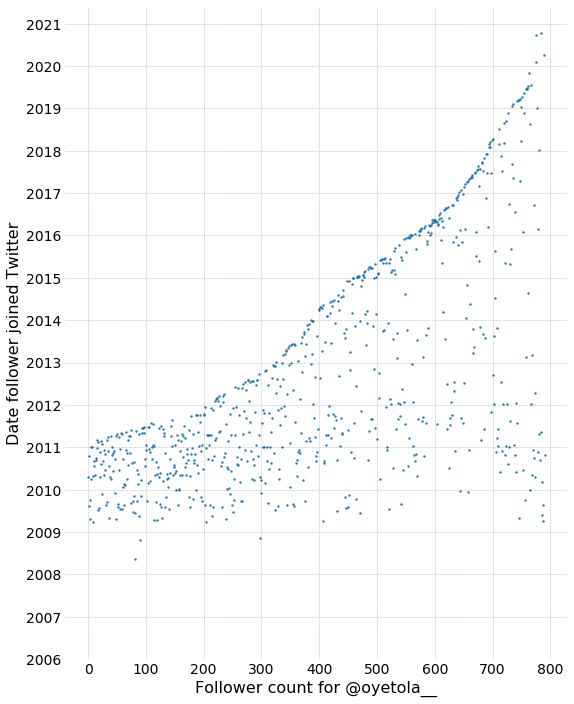

In [12]:
pbar = tqdm(total=len(followers))
pbar.write('Collecting join dates of Twitter followers for @{}'.format(USER_TO_ANALYZE))
followers_created = list()

rl_status = twitter_connection.application.rate_limit_status()
remaining_calls = rl_status['resources']['users']['/users/lookup']['remaining']

for base_index in range(0, len(followers), 100):
    if remaining_calls == 50:
        # Update the remaining calls count just in case
        rl_status = twitter_connection.application.rate_limit_status()
        remaining_calls = rl_status['resources']['users']['/users/lookup']['remaining']

    if remaining_calls <= 0:
        sleep_until = rl_status['resources']['users']['/users/lookup']['reset']
        sleep_for = int(sleep_until - time.time()) + 10 # wait a little extra time just in case
        if sleep_for > 0:
            pbar.write('Sleeping for {} seconds...'.format(sleep_for))
            time.sleep(sleep_for)
            pbar.write('Awake!')
            rl_status = twitter_connection.application.rate_limit_status()
            remaining_calls = rl_status['resources']['users']['/users/lookup']['remaining']

    remaining_calls -= 1

    # 100 users per request
    user_info = twitter_connection.users.lookup(user_id=list(followers[base_index:base_index + 100]))
    followers_created += [x['created_at'] for x in user_info]

    pbar.update(len(followers[base_index:base_index + 100]))

pbar.close()
print('Creating Follower Factory visualization for @{}'.format(USER_TO_ANALYZE))

days_since_2006 = [(x.year - 2006) * 365 + x.dayofyear for x in pd.to_datetime(followers_created)]

mpl_style_url = 'https://gist.githubusercontent.com/rhiever/d0a7332fe0beebfdc3d5/raw/1b807615235ff6f4c919b5b70b01a609619e1e9c/tableau10.mplstyle'
alpha = 0.1 * min(9, 80000. / len(days_since_2006))
with plt.style.context(mpl_style_url):
    plt.figure(figsize=(9, 12))
    plt.scatter(x=range(len(days_since_2006)), y=days_since_2006[::-1], s=2, alpha=alpha)
    plt.yticks(range(0, 365 * (datetime.today().year + 1 - 2006), 365), range(2006, datetime.today().year + 1))
    plt.xlabel('Follower count for @{}'.format(USER_TO_ANALYZE))
    plt.ylabel('Date follower joined Twitter')
    plt.savefig('{}-follower-factory.png'.format(USER_TO_ANALYZE))

print('Follower Factory visualization saved to {}'.format(os.getcwd()))